In [84]:
from datasets import load_dataset, load_metric
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import Sequential, layers, regularizers
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
import keras
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc, plot_confusion_matrix
import tensorflow.keras.optimizers 
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import keras.utils
import matplotlib as mpl
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2B0
from utils import *
from grad_cam import VizGradCAM
from tensorflow.keras.models import Model
import cv2
import visualkeras
from PIL import ImageFont
import os, datetime


In [85]:
# data_dir = r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-0.1"

In [86]:
data_dir = r"C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane"

In [87]:
batch_size = 16
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.9,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size= (img_height, img_width),
    batch_size=batch_size,
)


val_ds =  tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.9,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 8000 files belonging to 8 classes.
Using 800 files for training.
Found 8000 files belonging to 8 classes.
Using 7200 files for validation.


## Przegląd danych

In [88]:
# Extract class names
class_names = train_ds.class_names

# Count class instances in each dataset
train_class_counts = count_classes(train_ds, class_names)

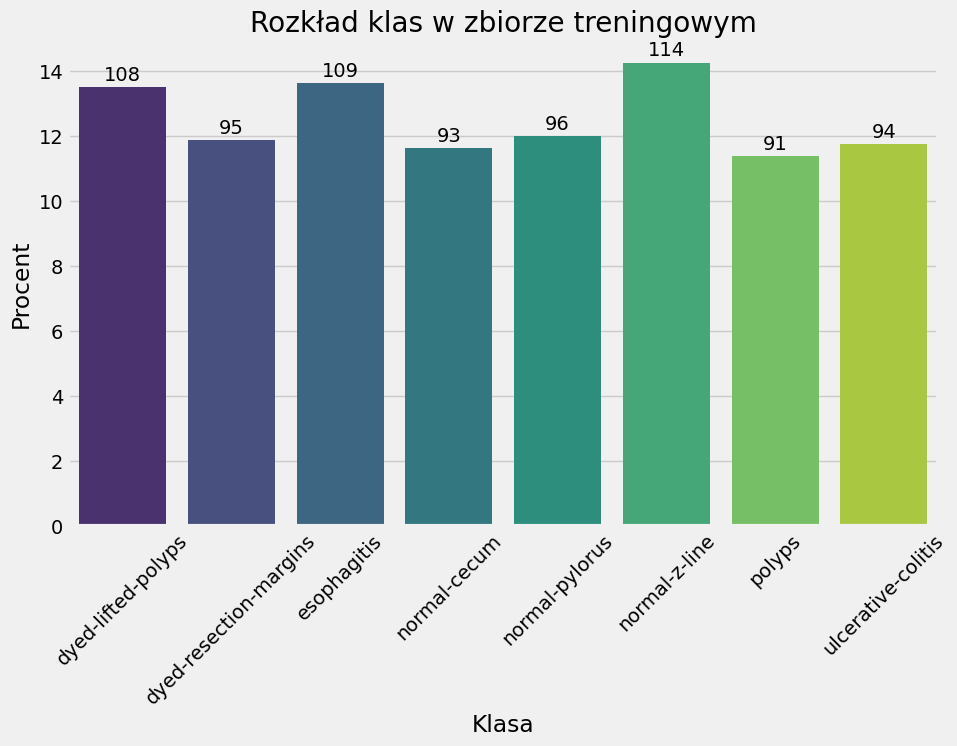

In [89]:
# Obliczenie całkowitej liczby instancji w każdym zbiorze
total_train_instances = sum(train_class_counts.values())
# Rysowanie wykresów
plot_class_distribution_seaborn(train_class_counts, 'Rozkład klas w zbiorze treningowym', total_train_instances)

In [90]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

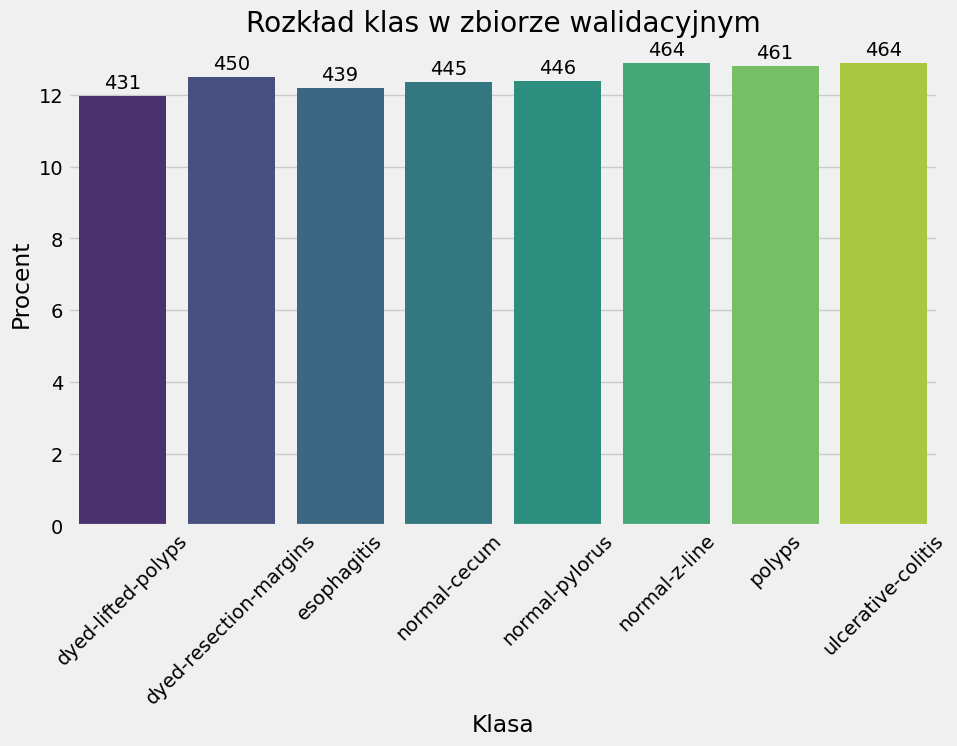

In [91]:
val_class_counts = count_classes(val_ds, class_names)
total_val_instances = sum(val_class_counts.values())
plot_class_distribution_seaborn(val_class_counts, 'Rozkład klas w zbiorze walidacyjnym', total_val_instances)

In [92]:
class_names = np.array(train_ds.class_names)
class_names

array(['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
       'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps',
       'ulcerative-colitis'], dtype='<U22')

In [93]:
test_ds = test_ds.unbatch()
test_ds = test_ds.batch(1)

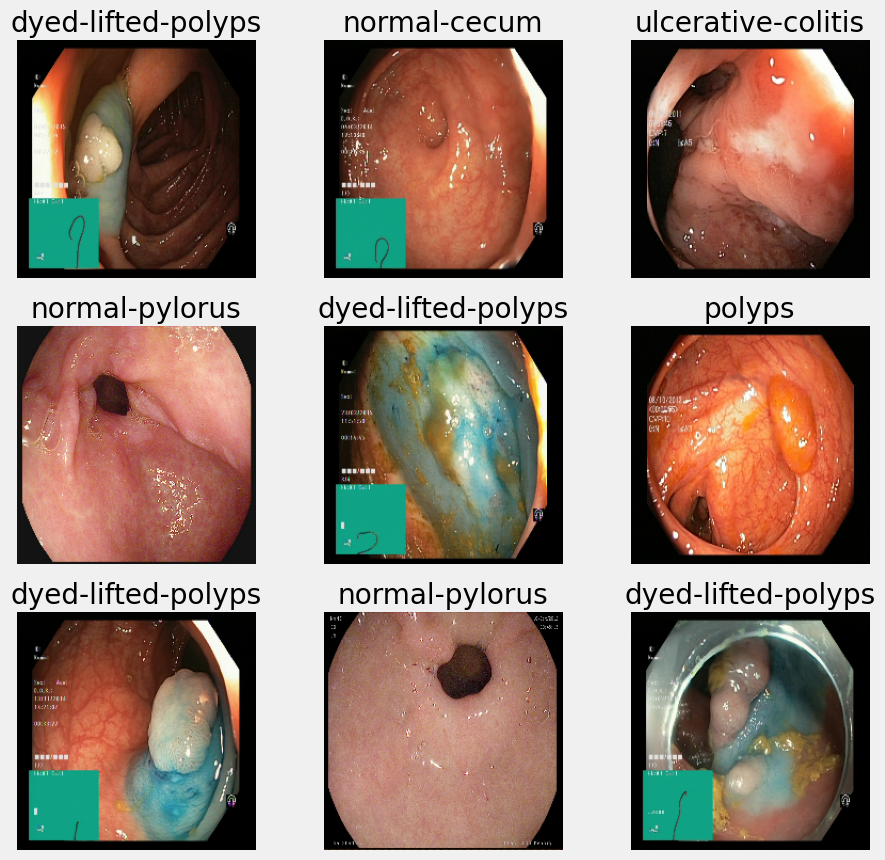

In [94]:
show_9_images_from_ds(train_ds, class_names)

In [95]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(10/360),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomContrast(factor=0.2),
]

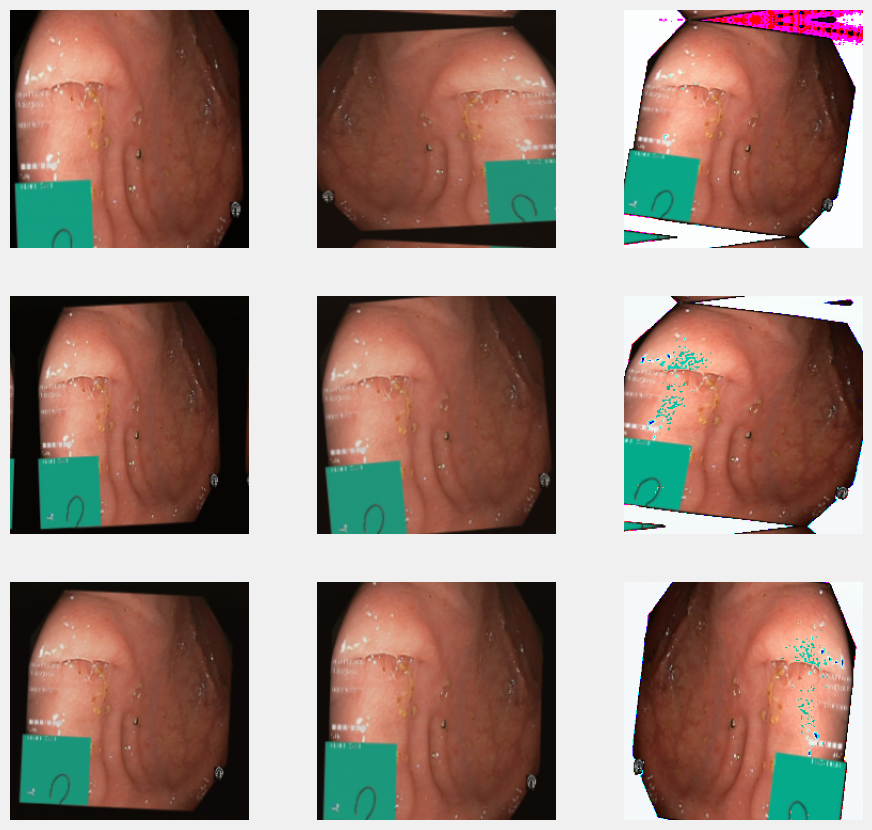

In [96]:
show_9_augmented_images(train_ds, data_augmentation_layers)

#### Normalizacja wartości piksela z przedziału [0,255] do [0,1]

In [97]:
rescale = Rescaling(scale=1.0/255)

In [98]:
rescale_layer = keras.Sequential(
    [
        layers.Rescaling(1.0 / 255), 
    ],
    name = "rescale"
)

#### Augmentacja danych zbioru uczącego

In [99]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, data_augmentation_layers), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

#### Ustalam liczbę epok dla wszystkich moedli

In [100]:
epochs = 100

## Model pierwszy

In [101]:
from collections import defaultdict


In [102]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'
color_map[Rescaling]['fill'] = 'black'
color_map[BatchNormalization]['fill'] = 'grey'

In [103]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    rescale,
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding = 'same',input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

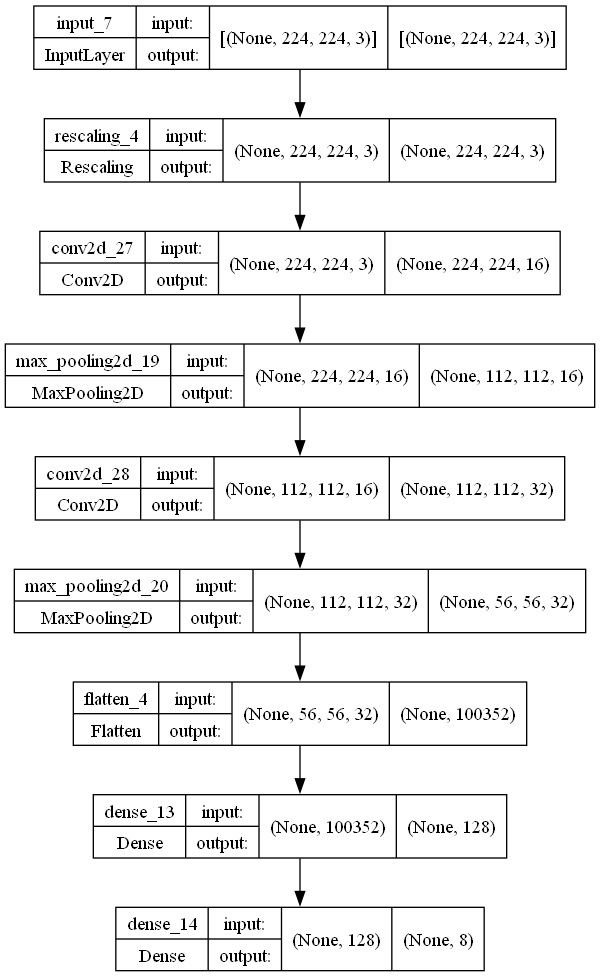

In [104]:
tf.keras.utils.plot_model(model1, to_file='model1_architecture.png', show_shapes=True, show_layer_names=True)

In [105]:
logdir1 = os.path.join("logs/fit/mri/model1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir1, histogram_freq=1)

In [106]:
model1.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

# best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model1_best_val_accuracy.h5",
#                                          save_weights_only=True,
#                                          mointor="val_accuracy",
#                                          mode="max",
#                                          save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=15, restore_best_weights=True)

history1 = model1.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stop, tensorboard_callback]
)

Epoch 1/100
50/50 [==============================] - 9s 179ms/step - loss: 1.8436 - accuracy: 0.3200 - val_loss: 1.1184 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 9s 166ms/step - loss: 1.0629 - accuracy: 0.5275 - val_loss: 0.9457 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 8s 162ms/step - loss: 0.9059 - accuracy: 0.5975 - val_loss: 0.8218 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 8s 160ms/step - loss: 0.8519 - accuracy: 0.6225 - val_loss: 0.9145 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 8s 158ms/step - loss: 0.7667 - accuracy: 0.6712 - val_loss: 0.7963 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 8s 158ms/step - loss: 0.7313 - accuracy: 0.6775 - val_loss: 0.7611 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 8s 159ms/st

## Model drugi

In [107]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    rescale,
    
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.gelu, input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(1024, (3, 3), activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [108]:
font = ImageFont.truetype("arial.ttf", 60) 
visualkeras.layered_view(model2, legend=True, font= font, to_file='model2.png', color_map=color_map).show() 

In [109]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_26 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_27 (Bat  (None, 109, 109, 64)    

In [110]:
model2.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

In [111]:
logdir2 = os.path.join("logs/fit/mri/model2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir2, histogram_freq=1)

In [112]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.85,
                              patience=10, min_lr=1e-5)

# best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model2_best_val_accuracy.h5",
#                                          save_weights_only=True,
#                                          mointor="val_accuracy",
#                                          mode="max",
#                                          save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history2 = model2.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stop, tensorboard_callback]
)

Epoch 1/100
50/50 [==============================] - 10s 179ms/step - loss: 1.4839 - accuracy: 0.4450 - val_loss: 5.1645 - val_accuracy: 0.1292 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 9s 168ms/step - loss: 1.1218 - accuracy: 0.5263 - val_loss: 5.2668 - val_accuracy: 0.1531 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 8s 164ms/step - loss: 1.0212 - accuracy: 0.5888 - val_loss: 2.7554 - val_accuracy: 0.1425 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 9s 169ms/step - loss: 0.9540 - accuracy: 0.5913 - val_loss: 3.0608 - val_accuracy: 0.1306 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 9s 166ms/step - loss: 0.9704 - accuracy: 0.5738 - val_loss: 3.6487 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 8s 164ms/step - loss: 0.9440 - accuracy: 0.5950 - val_loss: 1.5026 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 9s 168ms/s

## Model trzeci

Dodano 2 warstwy dropoutoraz regularyzację

In [113]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    rescale,
    # Convolutional layers with batch normalization and max pooling
    tf.keras.layers.Conv2D(32, (3, 3), activation=None, input_shape=(224, 224, 3)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation=None, kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(1024, (3, 3), activation=None),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    # Flatten the output and add Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [114]:
font = ImageFont.truetype("arial.ttf", 60) 
visualkeras.layered_view(model3, legend=True, font= font, to_file='model3.png', color_map=color_map).show() 

In [115]:
logdir3 = os.path.join("logs/fit/mri/model3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir3, histogram_freq=1)

In [116]:
model3.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

# best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model3_best_val_accuracy.h5",
#                                          save_weights_only=True,
#                                          mointor="val_accuracy",
#                                          mode="max",
#                                          save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=20, restore_best_weights=True)

history3 = model3.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stop, tensorboard_callback]
)

Epoch 1/100
50/50 [==============================] - 9s 165ms/step - loss: 11.2755 - accuracy: 0.4487 - val_loss: 13.3944 - val_accuracy: 0.1256 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 8s 160ms/step - loss: 8.7927 - accuracy: 0.5038 - val_loss: 9.9822 - val_accuracy: 0.1533 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 8s 160ms/step - loss: 6.3823 - accuracy: 0.5537 - val_loss: 7.6906 - val_accuracy: 0.1242 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 8s 160ms/step - loss: 4.5997 - accuracy: 0.5700 - val_loss: 6.9430 - val_accuracy: 0.2197 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 8s 164ms/step - loss: 3.4831 - accuracy: 0.5675 - val_loss: 5.2505 - val_accuracy: 0.2072 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 8s 156ms/step - loss: 2.6381 - accuracy: 0.5825 - val_loss: 3.1444 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 8s 159ms/

## Model czwarty - VGG16

In [117]:
from tensorflow.keras.regularizers import l2


In [118]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    rescale,
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), padding="valid", activation="relu"),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding="valid", activation="relu"),
    BatchNormalization(),
    Conv2D(512, (3, 3), padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Dodanie regularyzacji L2
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])


In [119]:
# font = ImageFont.truetype("arial.ttf", 60) 
# visualkeras.layered_view(model4, legend=True, font= font, to_file='model4.png', color_map=color_map).show() 

In [120]:
logdir4 = os.path.join("logs/fit/mri/model4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir4, histogram_freq=1)

In [121]:
model4.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

# best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model4_best_val_accuracy.h5",
#                                          save_weights_only=True,
#                                          mointor="val_accuracy",
#                                          mode="max",
#                                          save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=20, restore_best_weights=True)

history4 = model4.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stop, tensorboard_callback]
)

Epoch 1/100
50/50 [==============================] - 15s 279ms/step - loss: 3.8114 - accuracy: 0.1950 - val_loss: 2.6089 - val_accuracy: 0.1286 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 14s 268ms/step - loss: 2.8245 - accuracy: 0.1762 - val_loss: 2.5608 - val_accuracy: 0.1267 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 14s 271ms/step - loss: 2.6218 - accuracy: 0.1600 - val_loss: 2.5108 - val_accuracy: 0.1581 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 14s 270ms/step - loss: 2.5154 - accuracy: 0.1937 - val_loss: 2.4296 - val_accuracy: 0.1858 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 14s 272ms/step - loss: 2.4521 - accuracy: 0.1975 - val_loss: 2.3325 - val_accuracy: 0.2011 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 14s 270ms/step - loss: 2.4105 - accuracy: 0.2175 - val_loss: 2.3499 - val_accuracy: 0.2067 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 14s 2

Epoch 52/100
50/50 [==============================] - 13s 264ms/step - loss: 1.1088 - accuracy: 0.5275 - val_loss: 1.0183 - val_accuracy: 0.5608 - lr: 4.0960e-04
Epoch 53/100
50/50 [==============================] - 14s 272ms/step - loss: 1.0216 - accuracy: 0.5738 - val_loss: 0.9095 - val_accuracy: 0.6125 - lr: 4.0960e-04
Epoch 54/100
50/50 [==============================] - 14s 273ms/step - loss: 1.0331 - accuracy: 0.5800 - val_loss: 0.9433 - val_accuracy: 0.6078 - lr: 3.2768e-04
Epoch 55/100
50/50 [==============================] - 14s 279ms/step - loss: 1.0237 - accuracy: 0.5325 - val_loss: 1.2495 - val_accuracy: 0.5486 - lr: 3.2768e-04
Epoch 56/100
50/50 [==============================] - 14s 273ms/step - loss: 0.9636 - accuracy: 0.5525 - val_loss: 0.9257 - val_accuracy: 0.5839 - lr: 3.2768e-04
Epoch 57/100
50/50 [==============================] - 14s 275ms/step - loss: 1.0156 - accuracy: 0.5537 - val_loss: 0.9160 - val_accuracy: 0.5906 - lr: 3.2768e-04
Epoch 58/100
50/50 [========

## Model piąty - Efficentnet_v2

In [122]:
base_efficientnet_v2_model = EfficientNetV2B0(include_top = False, 
                                             input_shape = (224, 224, 3),
                                             weights = 'imagenet')

In [123]:
base_efficientnet_v2_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  0          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                  

 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]',     
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 192)  9216        ['block3b_add[0][0]']            
          

 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 384)  1536       ['block4c_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
          

 block5d_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_a

                                                                                                  
 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6b_expand_activation[0][0]
 2D)      

 block6d_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6d_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePoolin

 block6f_se_squeeze (GlobalAver  (None, 1152)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6f_activation[0][0]',     
          

 block6h_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6h_activation[0][0]',     
                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_add (Add)              (None, 7, 7, 192)    0           ['block6h_project_bn[0][0]',     
                                                                  'block6g_add[0][0]']            
          

In [124]:
base_efficientnet_v2_model.layers[1].scale == 1/255

True

In [125]:
base_efficientnet_v2_model = EfficientNetV2B0(include_top = False, 
                                             input_shape = (224, 224, 3),
                                             weights = 'imagenet')
base_efficientnet_v2_model.layers[1].scale == 1/255
model5 = base_efficientnet_v2_model.output
model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
model5 = tf.keras.layers.Dropout(0.5)(model5)
model5 = tf.keras.layers.Dense(len(class_names), activation='softmax')(model5)
model5 = Model(inputs=base_efficientnet_v2_model.input,
              outputs=model5)
model5.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model5_best_val_accuracy.h5",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=15, restore_best_weights=True)

history5 = model5.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop]
)

Epoch 1/100
50/50 [==============================] - 18s 227ms/step - loss: 0.9798 - accuracy: 0.6288 - val_loss: 0.5405 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 11s 210ms/step - loss: 0.5446 - accuracy: 0.8000 - val_loss: 0.6105 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 10s 203ms/step - loss: 0.3951 - accuracy: 0.8562 - val_loss: 0.4942 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 11s 206ms/step - loss: 0.2977 - accuracy: 0.8925 - val_loss: 0.4830 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 11s 207ms/step - loss: 0.3096 - accuracy: 0.8900 - val_loss: 0.9219 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 10s 203ms/step - loss: 0.2516 - accuracy: 0.9125 - val_loss: 0.6147 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 11s 2

In [126]:
base_efficientnet_v2_model.trainable = True
print(len(base_efficientnet_v2_model.layers))

255


In [127]:
model5 = base_efficientnet_v2_model.output
model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
model5 = tf.keras.layers.Dropout(0.5)(model5)
model5 = tf.keras.layers.Dense(len(class_names), activation='softmax')(model5)
model5 = Model(inputs=base_efficientnet_v2_model.input,
              outputs=model5)

In [128]:
font = ImageFont.truetype("arial.ttf", 60) 
visualkeras.layered_view(model5, legend=True, font= font, to_file='model5.png', color_map=color_map).show() 

In [129]:
model5.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  0          ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                           

 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]',     
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 28, 28, 192)  9216        ['block3b_add[0][0]']            
          

 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 14, 14, 384)  1536       ['block4c_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
          

 block5d_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_a

                                                                                                  
 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6b_expand_activation[0][0]
 2D)      

 block6d_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6d_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePoolin

 block6f_se_squeeze (GlobalAver  (None, 1152)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6f_activation[0][0]',     
          

 block6h_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6h_activation[0][0]',     
                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_add (Add)              (None, 7, 7, 192)    0           ['block6h_project_bn[0][0]',     
                                                                  'block6g_add[0][0]']            
          

In [130]:
logdir5 = os.path.join("logs/fit/mri/model5", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir5, histogram_freq=1)

In [131]:
model5.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-5)

# best = keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model5_best_val_accuracy.h5",
#                                          save_weights_only=True,
#                                          mointor="val_accuracy",
#                                          mode="max",
#                                          save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=15, restore_best_weights=True)

history5 = model5.fit(
    train_ds,
    epochs= epochs,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stop, tensorboard_callback]
)

Epoch 1/100
50/50 [==============================] - 18s 244ms/step - loss: 0.4879 - accuracy: 0.8575 - val_loss: 0.6354 - val_accuracy: 0.8089 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 12s 231ms/step - loss: 0.2314 - accuracy: 0.9187 - val_loss: 0.7587 - val_accuracy: 0.8014 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 12s 231ms/step - loss: 0.2079 - accuracy: 0.9312 - val_loss: 0.5287 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 12s 231ms/step - loss: 0.1821 - accuracy: 0.9400 - val_loss: 0.3524 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 12s 231ms/step - loss: 0.1893 - accuracy: 0.9237 - val_loss: 0.6394 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 12s 233ms/step - loss: 0.1602 - accuracy: 0.9563 - val_loss: 0.4931 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 12s 2

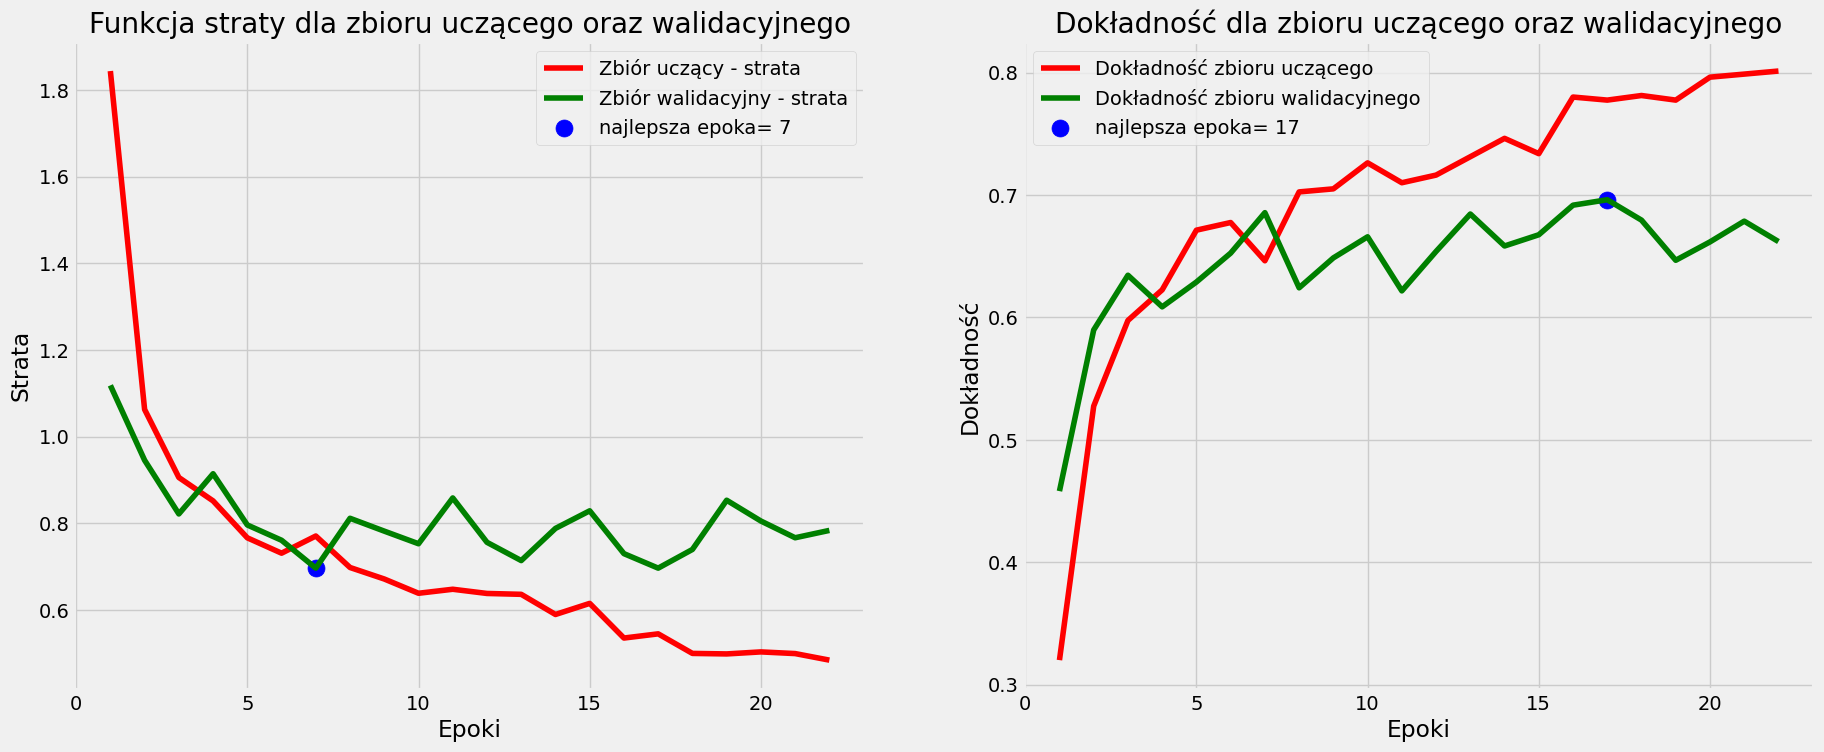

In [132]:
show_loss_accuracy_plots(history1)

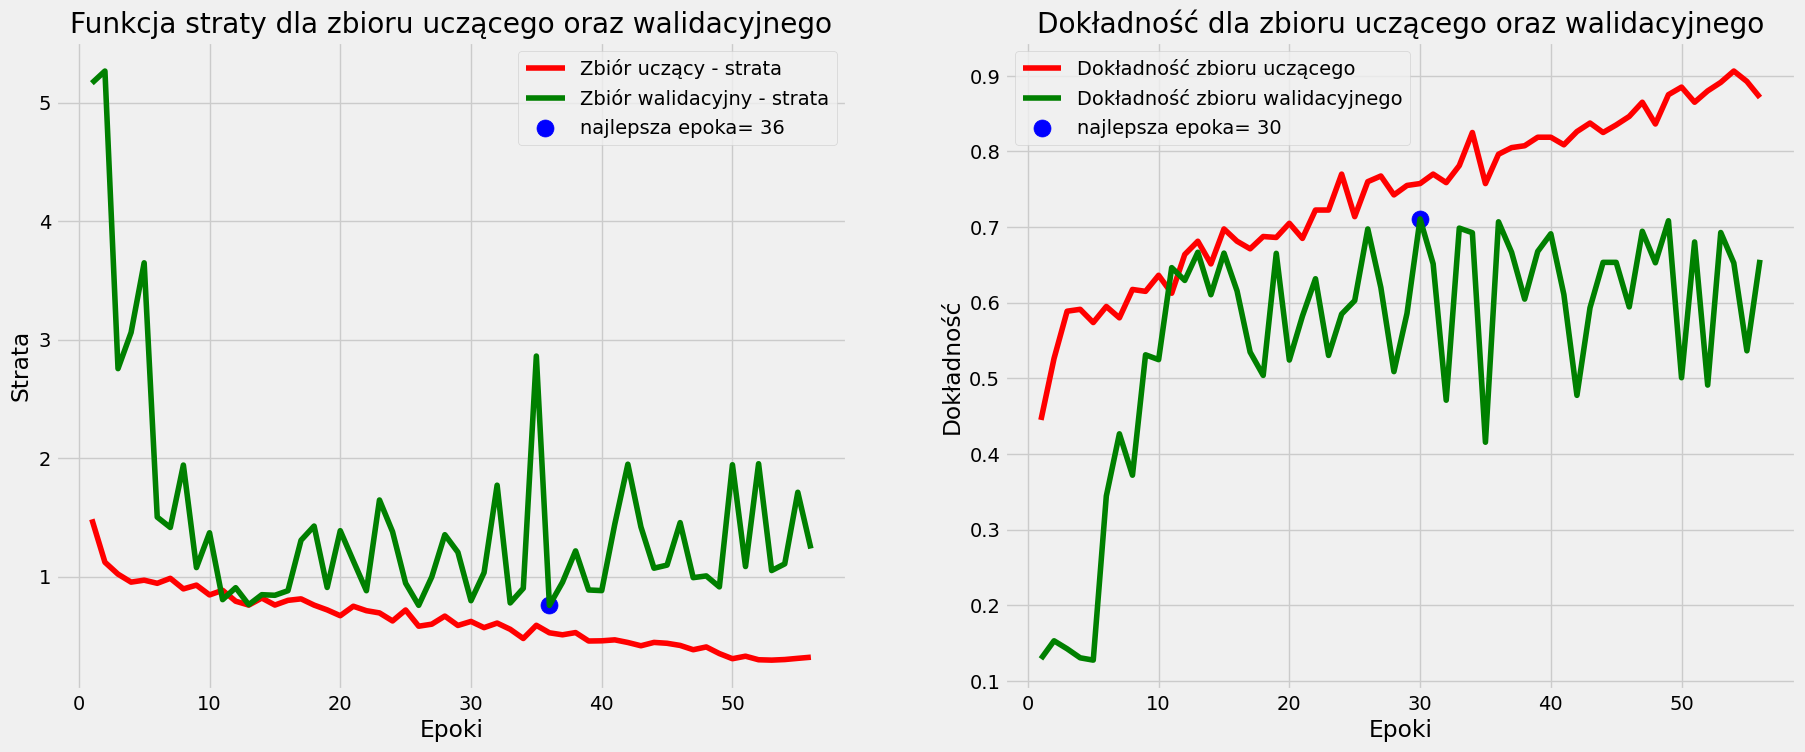

In [133]:
show_loss_accuracy_plots(history2)

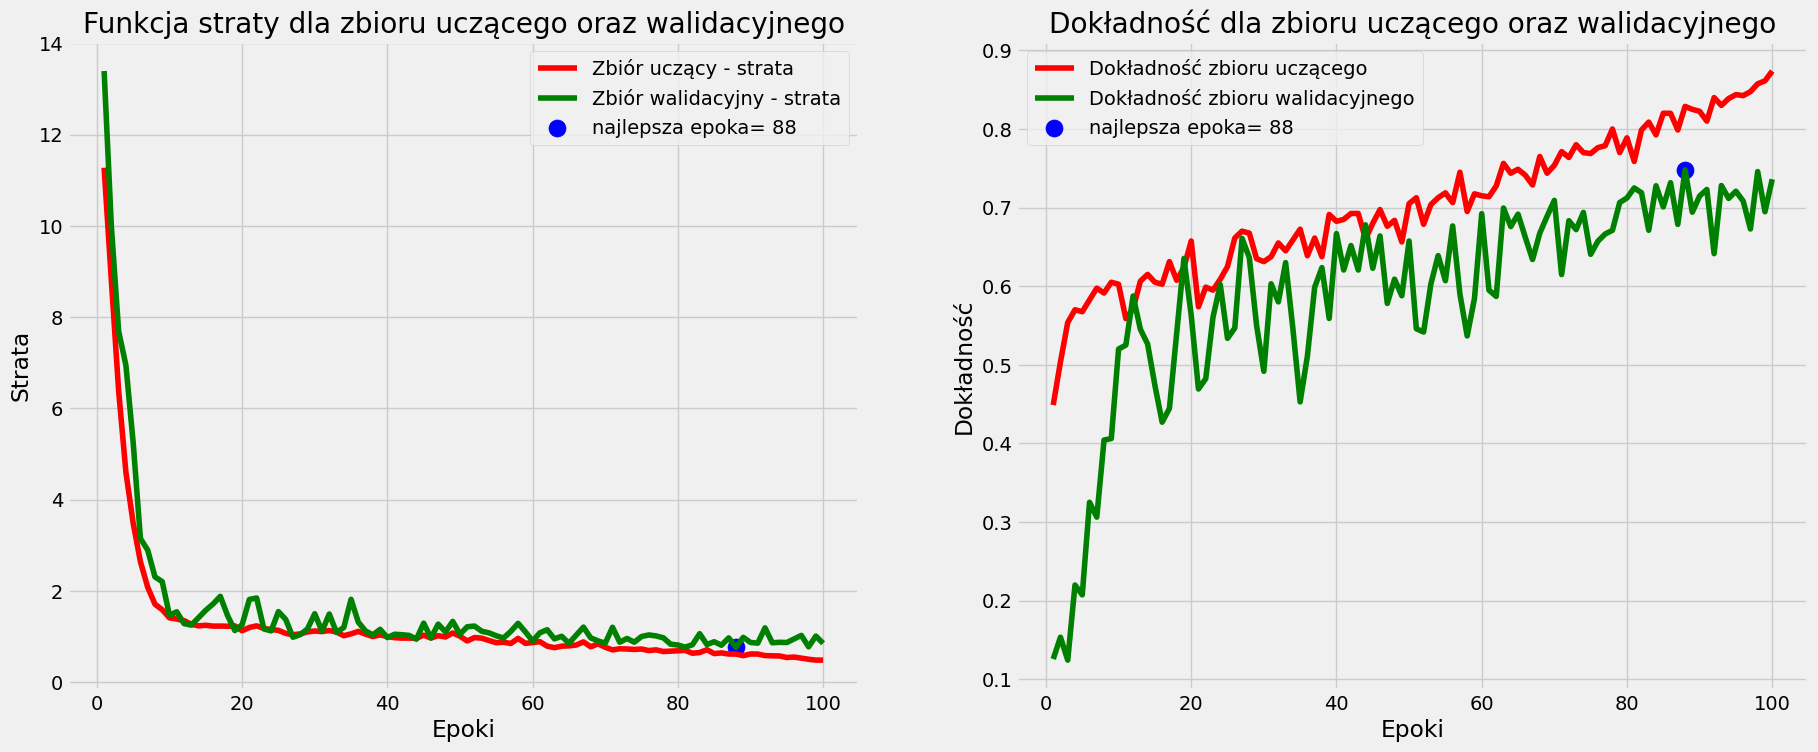

In [134]:
show_loss_accuracy_plots(history3)

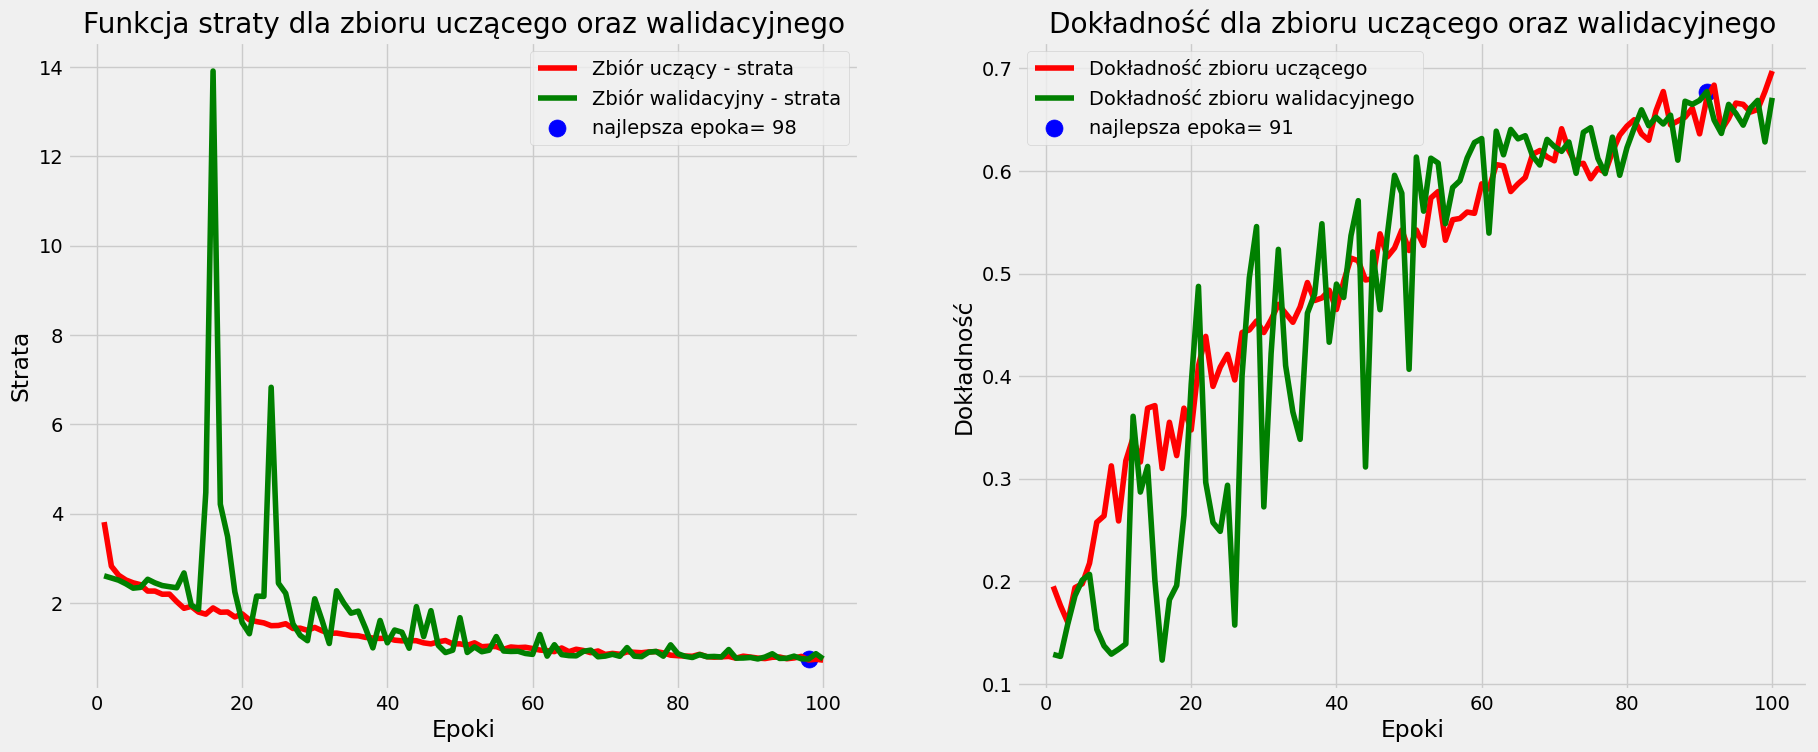

In [135]:
show_loss_accuracy_plots(history4)

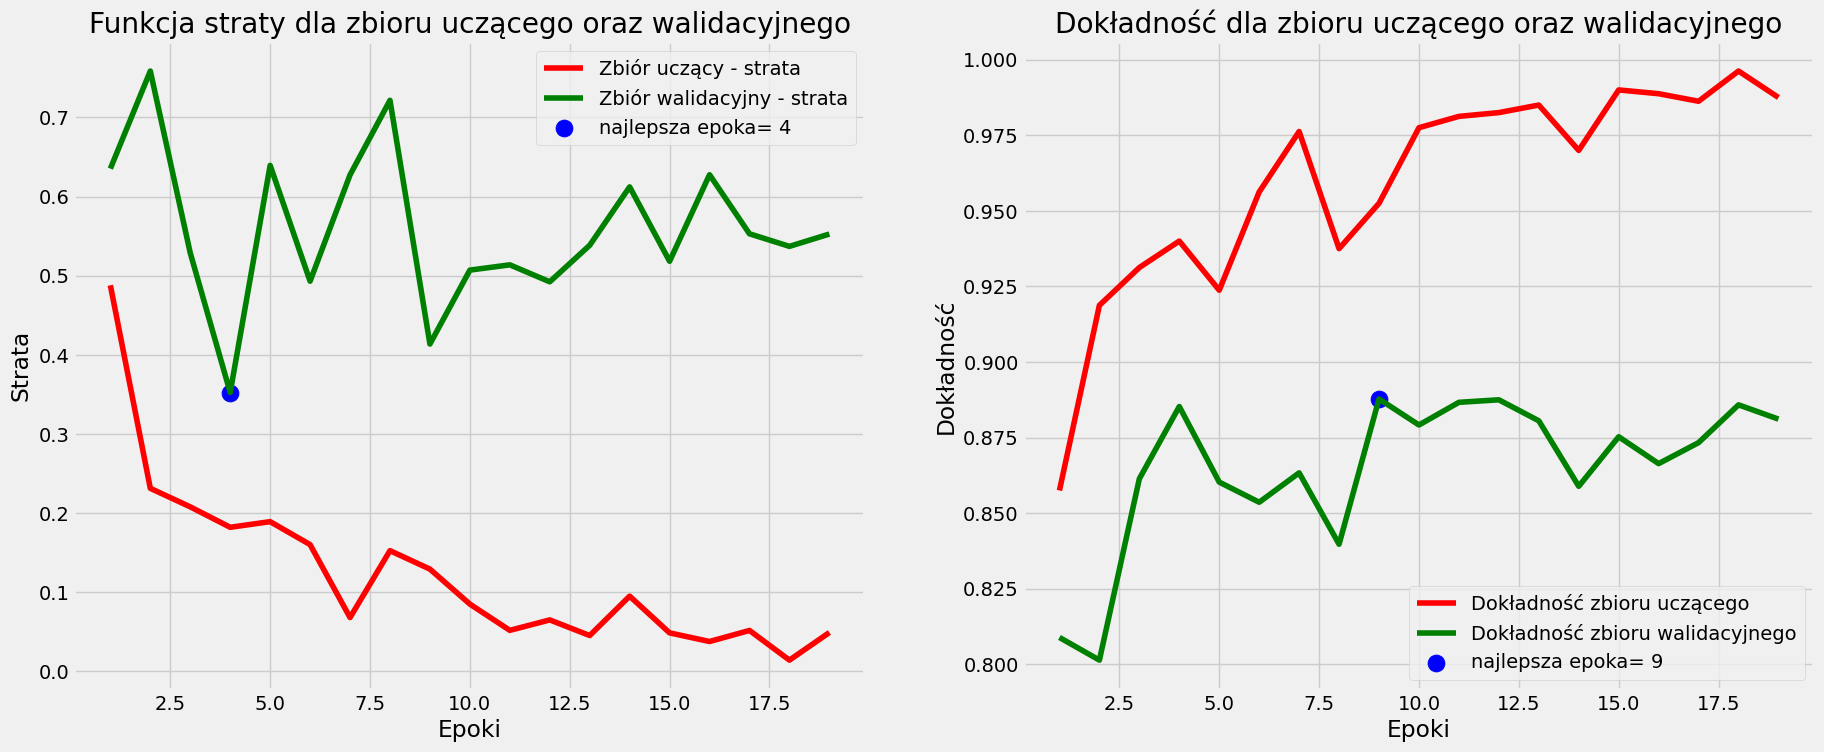

In [136]:
show_loss_accuracy_plots(history5)

## Ewaluacja i porównanie modeli

In [137]:
models = {
    'model1': model1,
    'model2': model2,
    'model3': model3,
    'model4': model4,
    'model5': model5,
}

In [138]:
best_models = find_best_model(models, test_ds)
for metric, (model_name, score) in best_models.items():
    print(f"Najlepszy model dla {metric}: {model_name} z wynikiem {score}")

Raport klasyfikacji dla model1:
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       456
           1       0.60      0.73      0.66       458
           2       0.69      0.74      0.72       453
           3       0.67      0.94      0.78       459
           4       0.89      0.96      0.93       455
           5       0.73      0.62      0.67       432
           6       0.65      0.48      0.55       445
           7       0.74      0.55      0.63       442

    accuracy                           0.69      3600
   macro avg       0.70      0.69      0.69      3600
weighted avg       0.70      0.69      0.69      3600

Raport klasyfikacji dla model2:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       461
           1       0.68      0.73      0.70       460
           2       0.75      0.52      0.61       451
           3       0.77      0.89      0.83       454
           4  

In [139]:
# model1.load_weights("training_weights/best/model1_best_val_accuracy.h5")
# model2.load_weights("training_weights/best/model2_best_val_accuracy.h5")
# model3.load_weights("training_weights/best/model3_best_val_accuracy.h5")
# model4.load_weights("training_weights/best/model4_best_val_accuracy.h5")
# model5.load_weights("training_weights/best/model6_best_val_accuracy.h5")

### Macierz pomyłek

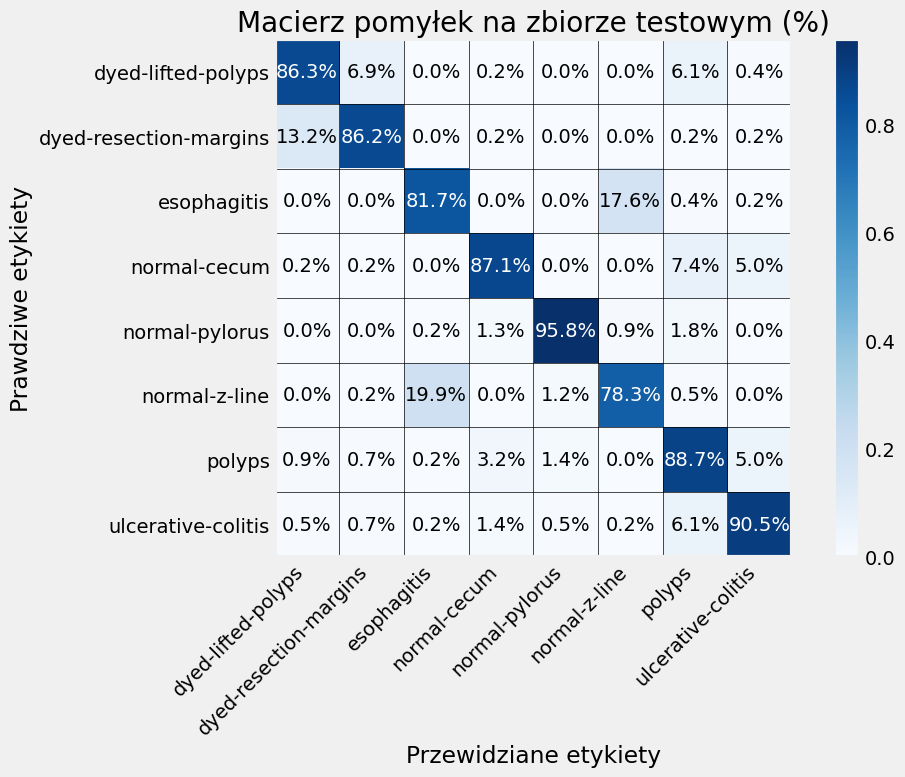

In [140]:
test_predictions, test_labels = get_predictions_and_labels(model5, test_ds)
cm_test = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek na zbiorze testowym (%)')

In [141]:
def plot_confusion_matrix_percent(cm, classes, title='Macierz pomyłek na zbiorze testowym (%)', figsize=(10, 8)):
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)

    plt.colorbar(im, ax=ax)

    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm_percent.max() / 2.

    for i, j in itertools.product(range(cm_percent.shape[0]), range(cm_percent.shape[1])):
        plt.text(j, i, "{:.1%}".format(cm_percent[i, j]),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

    for i in range(len(classes) + 1):
        ax.axhline(i - 0.5, linestyle='-', color='black', linewidth=0.5)
        ax.axvline(i - 0.5, linestyle='-', color='black', linewidth=0.5)

    plt.ylabel('Faktyczne etykiety')
    plt.xlabel('Przewidziane etykiety')
    
    plt.grid(False)
    plt.tight_layout()
    plt.show()

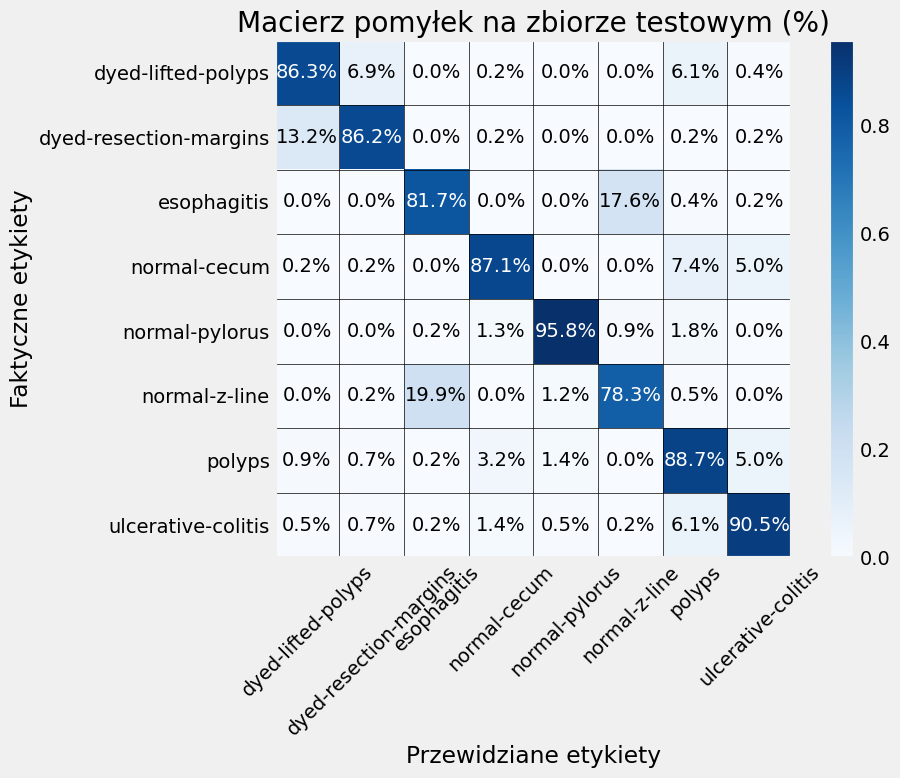

In [142]:
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek na zbiorze testowym (%)')

### Grad cam

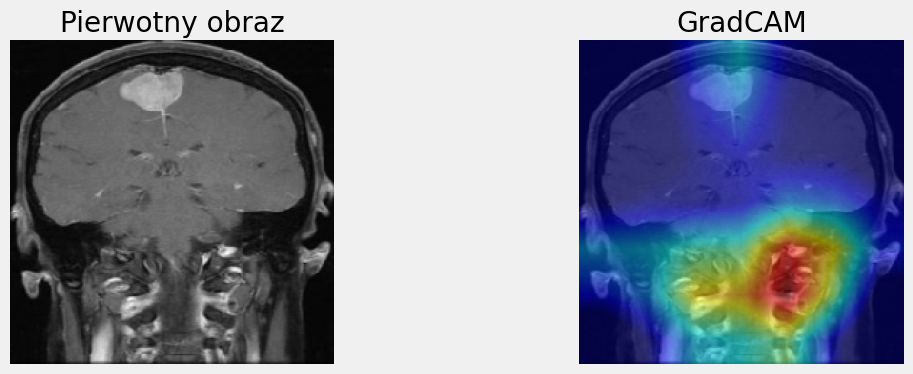

In [143]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\meningioma\50.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

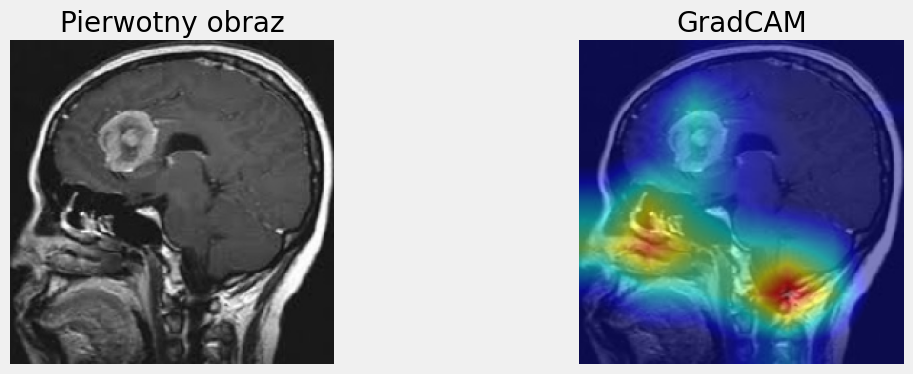

In [144]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\meningioma\60.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

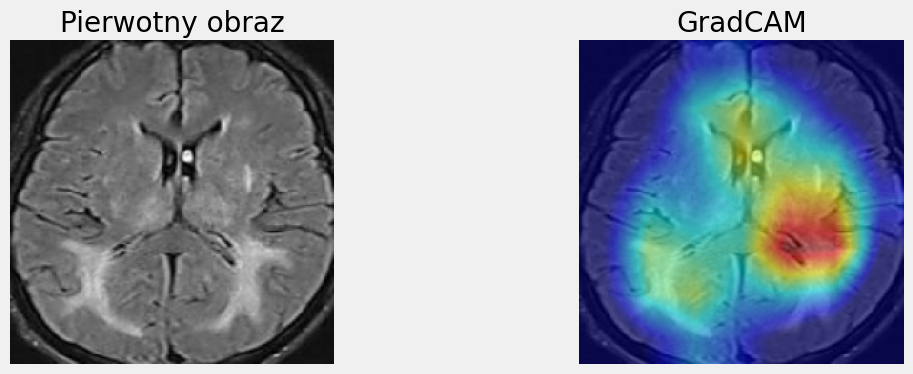

In [145]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\notumor\1.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

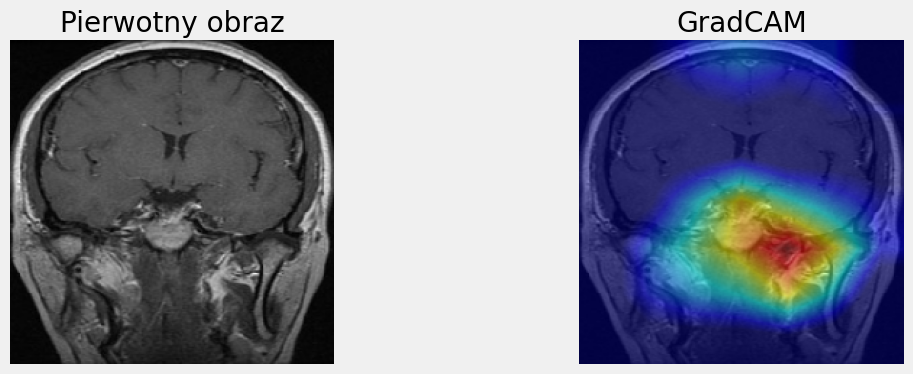

In [146]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\pituitary\85.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

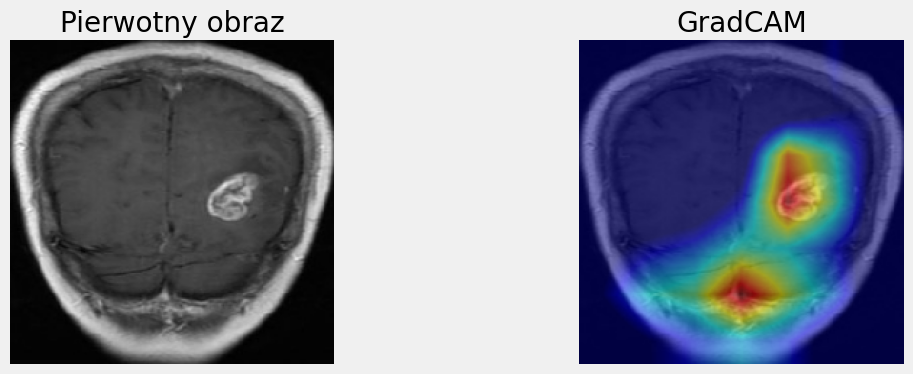

In [147]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\glioma\30.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

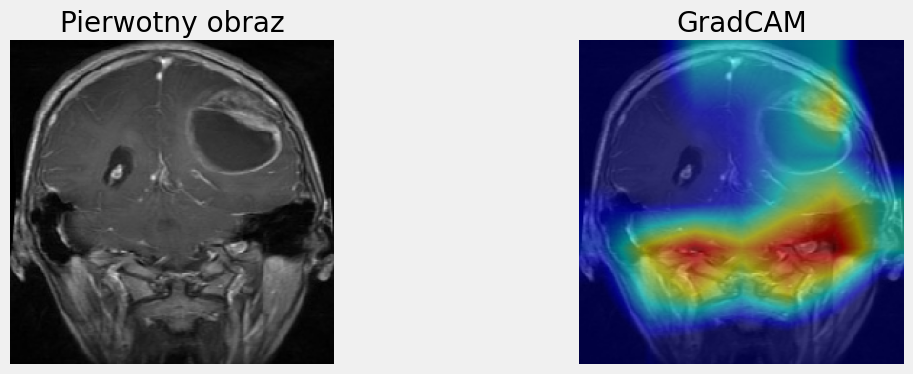

In [148]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\glioma\147.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

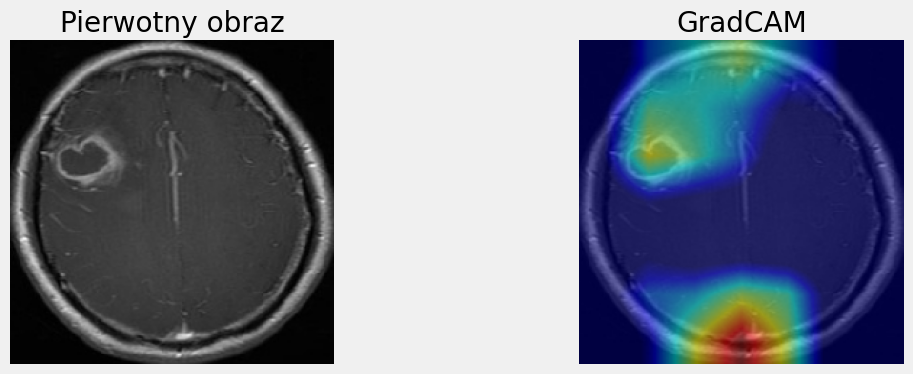

In [149]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\glioma\25.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

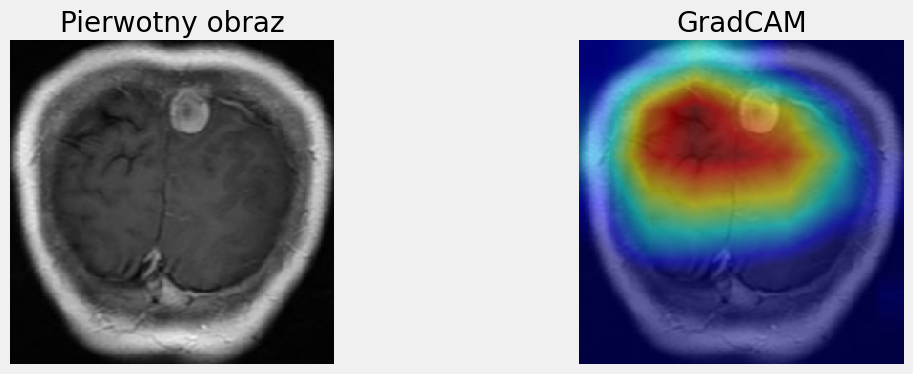

In [150]:
test_img = img_to_array(load_img(r"C:\Users\Jan\SGH\magisterka\dane\brain_tumor_mri_cropped\glioma\43.jpg" , target_size=(224,224)))

VizGradCAM(model5, test_img)

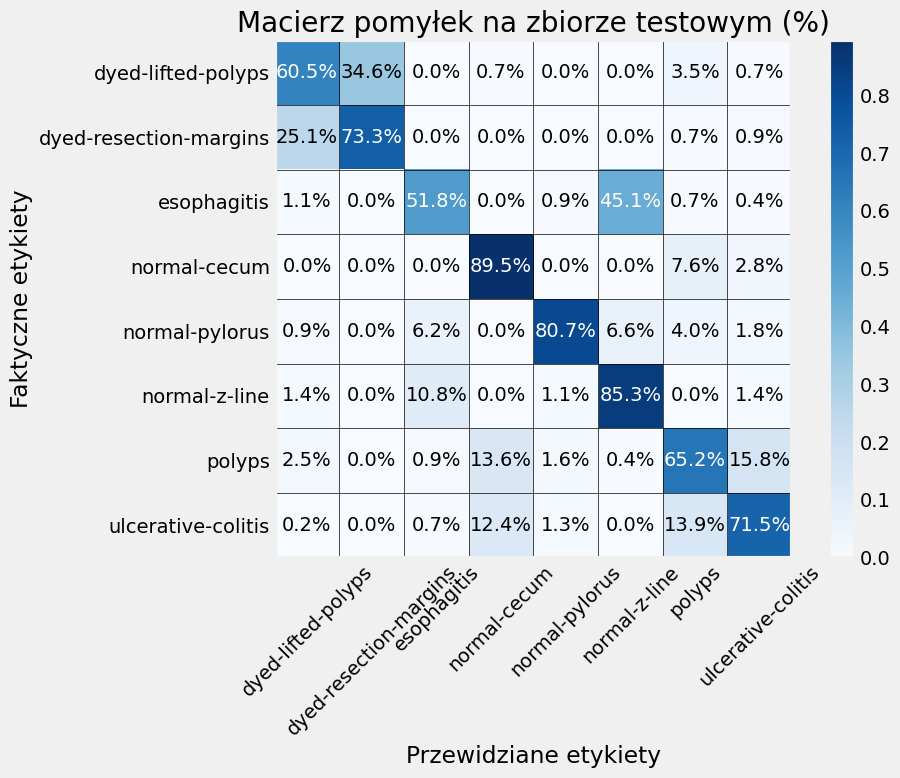

In [151]:
test_predictions, test_labels = get_predictions_and_labels(model2, test_ds)
cm_test = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek na zbiorze testowym (%)')

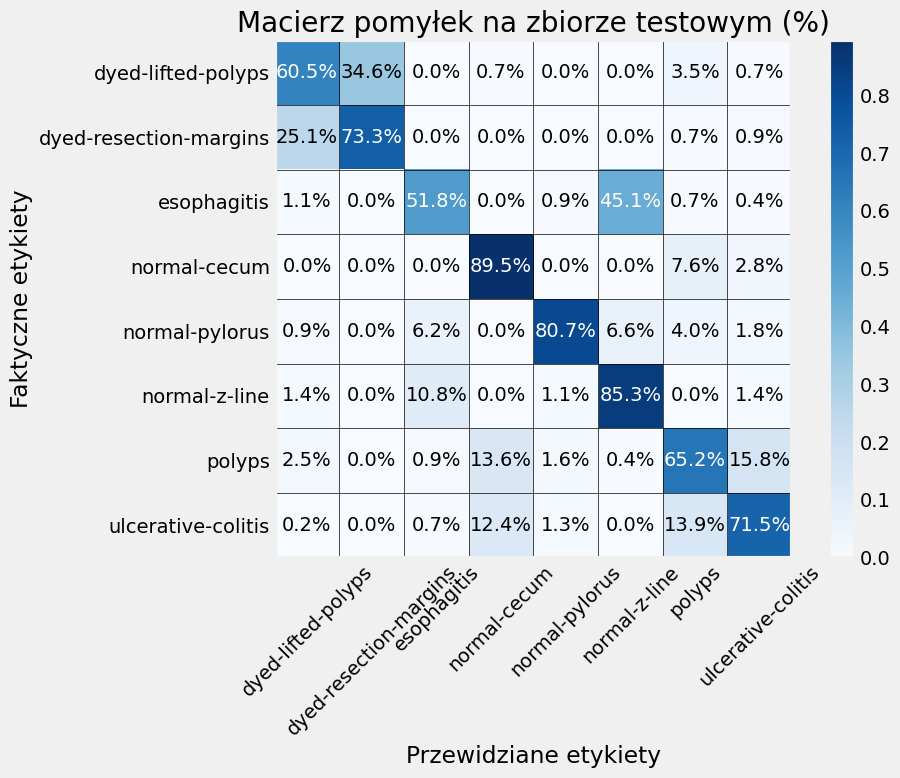

In [152]:
plot_confusion_matrix_percent(cm_test, class_names, 'Macierz pomyłek na zbiorze testowym (%)')

In [153]:
def save_models(folder_name, models=[model1, model2, model3, model4, model5]):
    base_path = r'C:\Users\Jan\SGH\magisterka\weights'
    
    full_path = os.path.join(base_path, folder_name)
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    for i, model in enumerate(models, start=1):
        model_path = os.path.join(full_path, f'model{i}.h5')
        print(f"Zapisywanie {model_path}...")  # Informacja o zapisie
        model.save(model_path)

In [154]:
models=[model1, model2, model3, model4, model5]
save_models("cnn-kvasir-10", models)

Zapisywanie C:\Users\Jan\SGH\magisterka\weights\cnn-kvasir-10\model1.h5...
Zapisywanie C:\Users\Jan\SGH\magisterka\weights\cnn-kvasir-10\model2.h5...
Zapisywanie C:\Users\Jan\SGH\magisterka\weights\cnn-kvasir-10\model3.h5...
Zapisywanie C:\Users\Jan\SGH\magisterka\weights\cnn-kvasir-10\model4.h5...
Zapisywanie C:\Users\Jan\SGH\magisterka\weights\cnn-kvasir-10\model5.h5...
